In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.ensemble import IsolationForest
%matplotlib inline

In [6]:
collegedata = pd.read_pickle('/home/michael/luther-project/data/careercollegestats.pkl')
playerdata = pd.read_pickle('/home/michael/luther-project/data/playerdatefull.pkl')

In [7]:
collegedata = collegedata[['G', 'MP', 'FG', 'FGA', '3P', '3PA','FT', 'FTA', 'ORB', 'TRB', 
                            'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','FG%', '3P%', 'FT%',
                            'avgMP', 'avgPTS', 'avgTRB', 'avgAST','name']]
collegedata = collegedata.drop(['ORB','3P%','3P','3PA','PF'],axis=1)

In [59]:
collegedata.isnull().sum()

0
G           0
MP        168
FG          1
FGA         1
FT          1
FTA         1
TRB         1
AST       421
STL       316
BLK       319
TOV       494
PTS         0
FG%         1
FT%         1
avgMP     168
avgPTS      0
avgTRB      1
avgAST    421
name        0
dtype: int64

In [53]:
def isolation_forest_sup(data,y,estimators,maxsamples,contamination,maxfeatures,randomstate):
    '''
    Function to fit iso and return predictions and anomaly score
    '''
    rng = np.random.RandomState(randomstate)
    isofor = IsolationForest(n_estimators = estimators,
                             max_samples = maxsamples,
                             contamination = contamination,
                             max_features = maxfeatures,
                             random_state = rng,
                             n_jobs = -1)
    isofor.fit(data,y)
    predict = isofor.predict(data)
    anomaly = isofor.decision_function(data)
    return anomaly, predict

In [54]:
def isolation_forest_unsup(data,estimators,maxsamples,contamination,maxfeatures,randomstate):
    '''
    Function to fit iso and return predictions and anomaly score
    '''
    rng = np.random.RandomState(randomstate)
    isofor = IsolationForest(n_estimators = estimators,
                             max_samples = maxsamples,
                             contamination = contamination,
                             max_features = maxfeatures,
                             random_state = rng,
                             n_jobs = -1)
    isofor.fit(data)
    predict = isofor.predict(data)
    anomaly = isofor.decision_function(data)
    return anomaly, predict

In [41]:
def graph_outliers(normalx,normaly,outlierx,outliery,xlabel,ylabel):
    '''
    Function to graph outliers in a standard way
    '''
    plt.subplots(1, figsize=(10, 5))
    b1 = plt.scatter(normalx, normaly, c='green',
                     s=40, edgecolor='k')
    b1 = plt.scatter(outlierx, outliery, c='orange',
                     s=40, edgecolor='k')
    plt.axis('tight')
    plt.xlim((-.5, .5))
    plt.ylim((-2, 7))
    plt.tick_params(axis = 'both',labelsize = 14)
    plt.xlabel(xlabel,fontsize = 16)
    plt.ylabel(ylabel,fontsize = 16,rotation = 0,labelpad=50);

In [151]:
playervorp = playerdata[['name','avgVORP','height']].copy(deep=True)
playervorp['y'] = np.where(playervorp['avgVORP']>2, -1, 1)
colvorp = pd.merge(collegedata, playervorp, how = 'inner')
colvorp = colvorp.drop_duplicates(subset='name',keep=False)
colvorp = colvorp.dropna()

colvorp.shape

(568, 22)

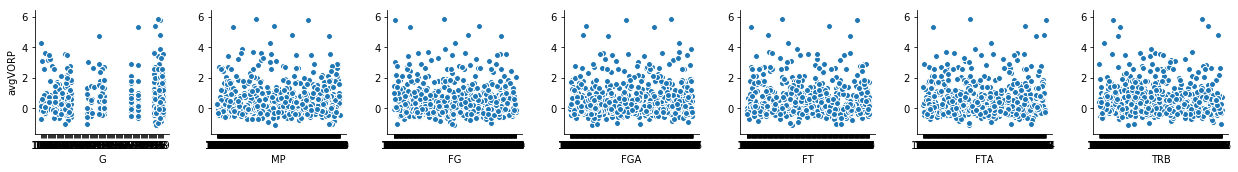

In [152]:
sns.pairplot(colvorp,y_vars=['avgVORP'],x_vars=['G', 'MP', 'FG', 'FGA','FT', 'FTA','TRB']);

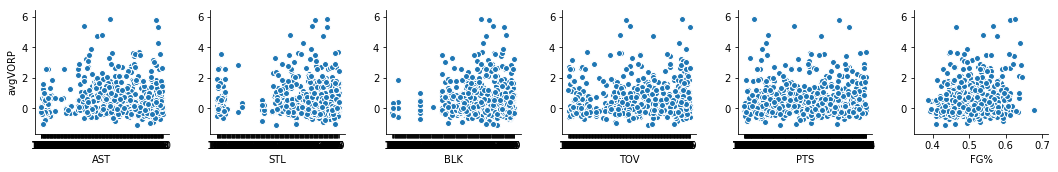

In [72]:
sns.pairplot(colvorp,y_vars=['avgVORP'],x_vars=['AST', 'STL', 'BLK', 'TOV', 'PTS','FG%']);

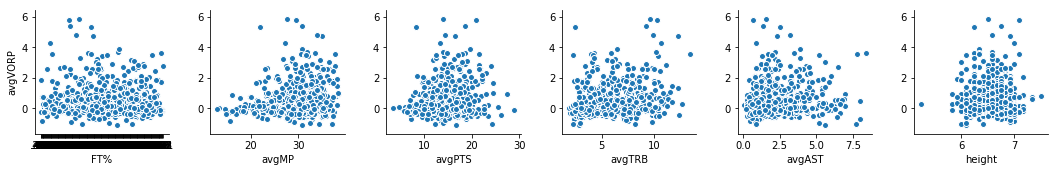

In [73]:
sns.pairplot(colvorp,y_vars=['avgVORP'],x_vars=['FT%','avgMP', 'avgPTS', 'avgTRB', 'avgAST','height']);

In [153]:
contamination = colvorp[colvorp['y']==-1].count()['y'] / len(colvorp.index)
contamination

0.096830985915492954

In [154]:
predict = colvorp[['name','avgVORP','y']].copy(deep=True)
train = colvorp.drop(['name','avgVORP','y'],axis = 1).copy(deep=True)

In [155]:
columns = ['avgPTS','avgTRB','avgAST','FG%','BLK','height','TRB']

['avgPTS', 'avgTRB', 'avgAST', 'FG%', 'BLK', 'height', 'TRB', 'STL']
[[ 14  41]
 [ 41 472]]
0.587311713628


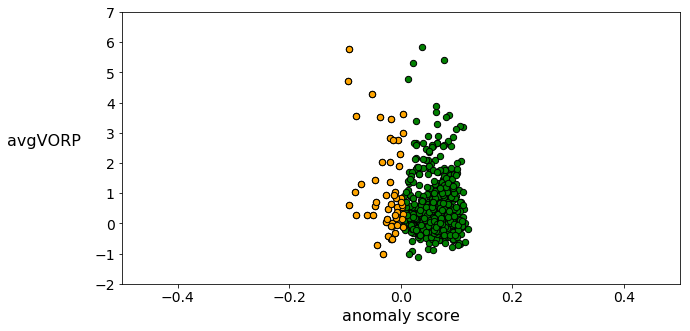

In [156]:
columns = ['avgPTS','avgTRB','avgAST','FG%','BLK','height','TRB','STL']
anomaly, prediction = isolation_forest_unsup(train[columns],1000,'auto',contamination,len(columns),42)
predict['anomaly'] = anomaly
predict['outlier'] = prediction
conf = confusion_matrix(predict['y'], predict['outlier'])
auc = roc_auc_score(predict['y'],predict['outlier'])
outliers = predict[predict['outlier']==-1].copy(deep=True)
graph_outliers(predict['anomaly'],predict['avgVORP'],outliers['anomaly'],outliers['avgVORP'],
               'anomaly score', 'avgVORP')
print(columns)
print(conf)
print(auc)

['avgTRB']
[[  9  46]
 [ 48 465]]
0.535034556087


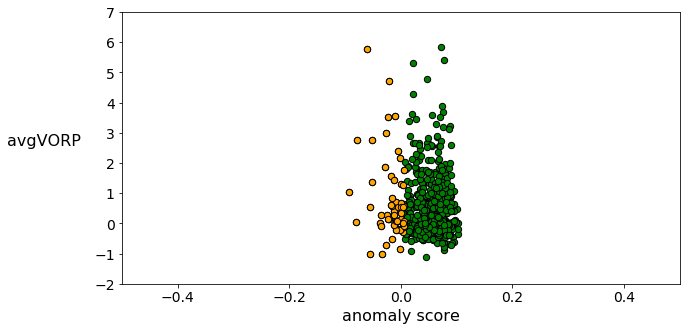

In [170]:

anomaly, prediction = isolation_forest_unsup(train,1000,'auto',.1,5,42)
predict['anomaly'] = anomaly
predict['outlier'] = prediction
conf = confusion_matrix(predict['y'], predict['outlier'])
auc = roc_auc_score(predict['y'],predict['outlier'])
outliers = predict[predict['outlier']==-1].copy(deep=True)
graph_outliers(predict['anomaly'],predict['avgVORP'],outliers['anomaly'],outliers['avgVORP'],
               'anomaly score', 'avgVORP')
print(columns)
print(conf)
print(auc)

['avgPTS', 'avgTRB', 'avgAST', 'BLK', 'height', 'STL', 'TRB']
[[  9  46]
 [ 46 467]]


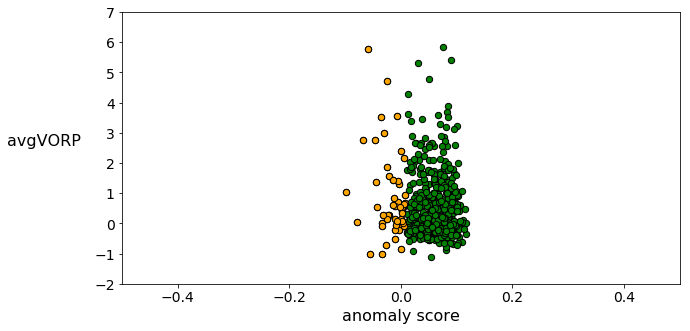

In [158]:
columns = ['avgPTS','avgTRB','avgAST','BLK','height','STL','TRB']
anomaly, prediction = isolation_forest_sup(train,predict['y'],1000,'auto',contamination,len(train.columns),42)
predict['anomaly'] = anomaly
predict['outlier'] = prediction
conf = confusion_matrix(predict['y'], predict['outlier'])
outliers = predict[predict['outlier']==-1].copy(deep=True)
graph_outliers(predict['anomaly'],predict['avgVORP'],outliers['anomaly'],outliers['avgVORP'],
               'anomaly score', 'avgVORP')
print(columns)
print(conf)